In [ ]:
import boto3
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

plt.style.use("default")
# sns.set_theme(style="white")


LOCAL_DIR = "data"

In [3]:
os.chdir("/home/jterryc/zrive-ds-JTC/src/data")

# Verificar dónde estás ahora
# print(os.listdir())

bb_df = pd.read_parquet("feature_frame.parquet", engine="fastparquet")

In [387]:
info_cols = ["variant_id","order_id","user_id","created_at","order_date"]
label_col = "outcome"
feature_cols = [col for col in bb_df.columns if col not in info_cols + [label_col]]

categorical_cols = ["product_type","vendor"]
binary_cols = ["ordered_before","abandoned_before","active_snoozed","set_as_regular"]
numerical_cols = [col for col in feature_cols if col not in categorical_cols + binary_cols]

In [5]:
# Otra forma de hacerlo (como lo hace Guille en la corrección) con el método .pipe()

def push_relevant_dataframe(df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame:
    order_size = df.groupby("order_id").outcome.sum()
    orders_of_min_size = order_size[order_size >= min_products].index
    return df.loc[lambda x: x.order_id.isin(orders_of_min_size)]

def format_date_columns(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df
        .assign(created_at=lambda x: pd.to_datetime(x.created_at))
        .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
    )

filtered_df = (
    bb_df
    .pipe(push_relevant_dataframe)
    .pipe(format_date_columns)
)

filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   variant_id                        int64         
 1   product_type                      object        
 2   order_id                          int64         
 3   user_id                           int64         
 4   created_at                        datetime64[ns]
 5   order_date                        object        
 6   user_order_seq                    int64         
 7   outcome                           float64       
 8   ordered_before                    float64       
 9   abandoned_before                  float64       
 10  active_snoozed                    float64       
 11  set_as_regular                    float64       
 12  normalised_price                  float64       
 13  discount_pct                      float64       
 14  vendor                 

Text(0.5, 1.0, 'Daily orders')

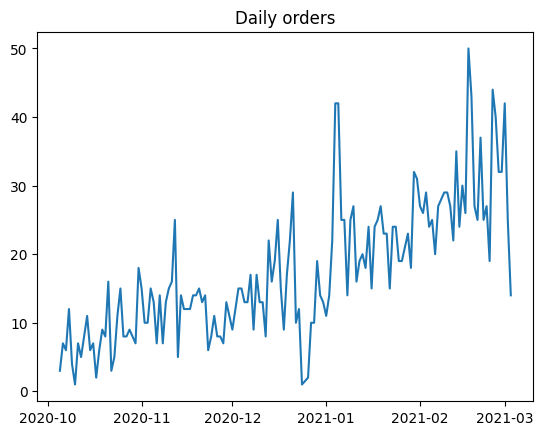

In [6]:
daily_orders = filtered_df.groupby("order_date").order_id.nunique()
daily_orders.head()

plt.plot(daily_orders, label="daily orders")
plt.title("Daily orders")

- Como se puede comprobar, hay una fuerte evolución temporal en el comportamiento de compra en el negocio, lo que nos viene a decir que las dinámicas de compra de los usuarios varían durante el período estudiado.
En este contexto, lo que tiene más sentido es realizar un **split de datos temporal**, de forma que en el training set no exista información futura y por tanto evitando information leakage.
- Information leakage ocurre cuando le damos al modelo cualquier información que no debería tener, ya que en producción NO la va a tener

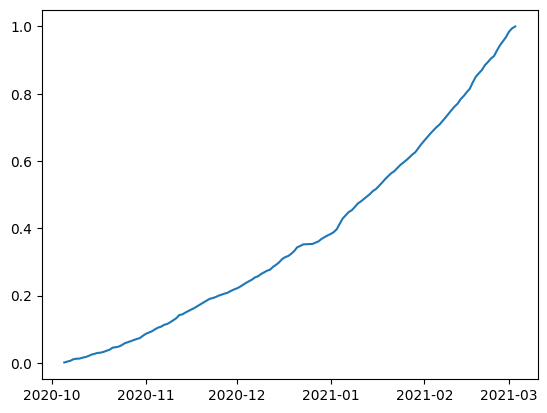

In [7]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()
plt.plot(cumsum_daily_orders)

Split temporal:
- Train: 70%
- Val: 20%
- Test: 10%

El split temporal se va a realizar en base al nº de pedidos, pero como esto no es constante en el tiempo, tendremos que hacer el split en base a la **suma acumulada**. Si se hiciera contando el nº de filas que representan el 70% en el df original:
- podríamos tener un train con pocos pedidos (si los primeros días tenían pocos),
- o un train con demasiados pedidos (si los últimos días concentraban muchos).

In [8]:
cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()

datetime.date(2021, 2, 4)

In [9]:
train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

In [ ]:
train_df = filtered_df[filtered_df.order_date <= train_val_cutoff]
val_df = filtered_df[
    (filtered_df.order_date > train_val_cutoff) & 
    (filtered_df.order_date <= val_test_cutoff)
    ]
test_df = filtered_df[filtered_df.order_date > val_test_cutoff]


,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [386]:
train_df

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879398,33826439594116,healthcarevitamins,2913918845060,3905854636164,2021-02-04 21:10:56,2021-02-04,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2879399,33826439594116,healthcarevitamins,2913925824644,3502430322820,2021-02-04 21:22:31,2021-02-04,8,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2879400,33826439594116,healthcarevitamins,2913955774596,3905623097476,2021-02-04 22:13:58,2021-02-04,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2879401,33826439594116,healthcarevitamins,2913958953092,3894986473604,2021-02-04 22:19:01,2021-02-04,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


In [11]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   variant_id                        int64         
 1   product_type                      object        
 2   order_id                          int64         
 3   user_id                           int64         
 4   created_at                        datetime64[ns]
 5   order_date                        object        
 6   user_order_seq                    int64         
 7   outcome                           float64       
 8   ordered_before                    float64       
 9   abandoned_before                  float64       
 10  active_snoozed                    float64       
 11  set_as_regular                    float64       
 12  normalised_price                  float64       
 13  discount_pct                      float64       
 14  vendor                 

In [80]:
val_df


,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
2300,33826472919172,ricepastapulses,2914201960580,3864345313412,2021-02-05 08:10:55,2021-02-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,21.0,30.0,24.276180
2302,33826472919172,ricepastapulses,2914226241668,3782964576388,2021-02-05 09:22:59,2021-02-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,116.0,30.0,24.276180
2304,33826472919172,ricepastapulses,2914238365828,3900620734596,2021-02-05 09:55:14,2021-02-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,17.0,30.0,24.276180
2305,33826472919172,ricepastapulses,2914245181572,3912666054788,2021-02-05 10:15:54,2021-02-05,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180
2306,33826472919172,ricepastapulses,2914246656132,3813120245892,2021-02-05 10:18:50,2021-02-05,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,19.0,30.0,24.276180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880155,33826439594116,healthcarevitamins,2928177217668,3868064153732,2021-02-22 19:31:18,2021-02-22,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880157,33826439594116,healthcarevitamins,2928220635268,3532684066948,2021-02-22 20:30:43,2021-02-22,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880158,33826439594116,healthcarevitamins,2928232857732,3823832957060,2021-02-22 20:47:46,2021-02-22,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392
2880159,33826439594116,healthcarevitamins,2928289710212,3476069580932,2021-02-22 22:16:01,2021-02-22,6,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,34.0,27.693045,30.0,34.0,27.451392


### Baseline

Necesitamos un modelo simple, que ni si quiera requiera ML, que nos sirva de **referencia** para poder evaluar nuestros modelos "inteligentes" (de ML), confirmando que son mejores que la referencia. Podemos tener 1 o varios baselines con los que comparar nuestro modelo de ML

In [12]:
import matplotlib

def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        target_precision: float = 0.05,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
    
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title("Precision-recall- Curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC:{roc_auc:.2f} ")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title("ROC curve")
    ax[1].legend()

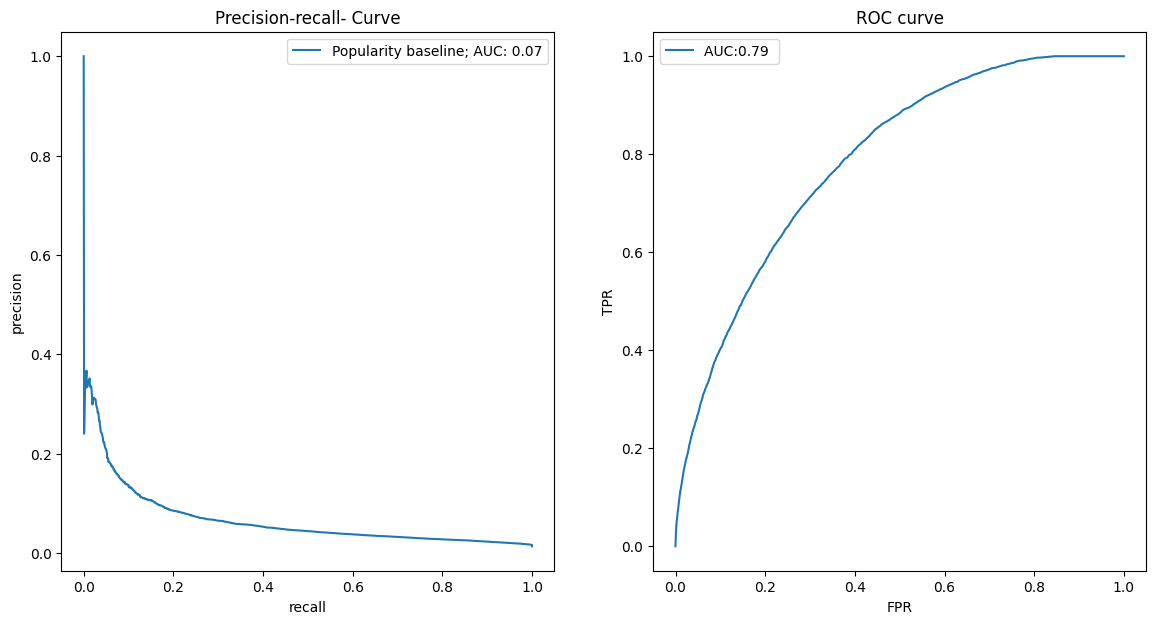

In [13]:
plot_metrics(
    "Popularity baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col]
)

## Model training

In [78]:
def feature_label_split(
        df: pd.DataFrame, label_col: str
) -> Tuple[pd.DataFrame, pd.Series]:
    X = df.drop(columns=label_col)
    y = df[label_col]
    return X, y

In [170]:
X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)

In [388]:
train_cols = numerical_cols + binary_cols
train_cols

['user_order_seq',
 'normalised_price',
 'discount_pct',
 'global_popularity',
 'count_adults',
 'count_children',
 'count_babies',
 'count_pets',
 'people_ex_baby',
 'days_since_purchase_variant_id',
 'avg_days_to_buy_variant_id',
 'std_days_to_buy_variant_id',
 'days_since_purchase_product_type',
 'avg_days_to_buy_product_type',
 'std_days_to_buy_product_type',
 'ordered_before',
 'abandoned_before',
 'active_snoozed',
 'set_as_regular']

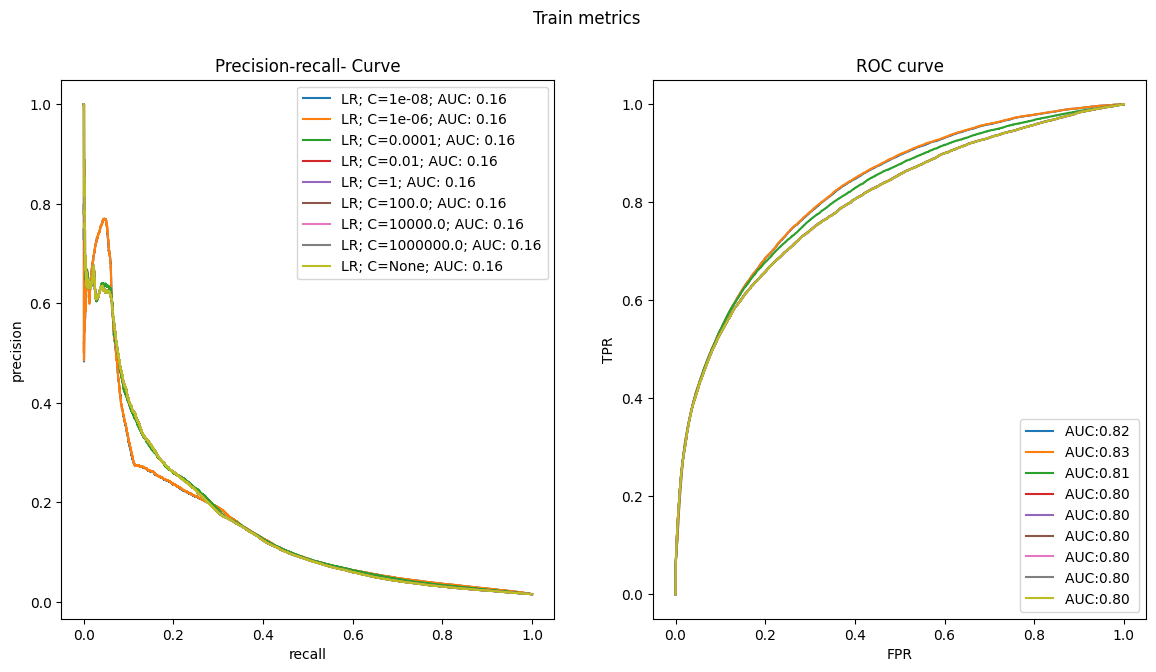

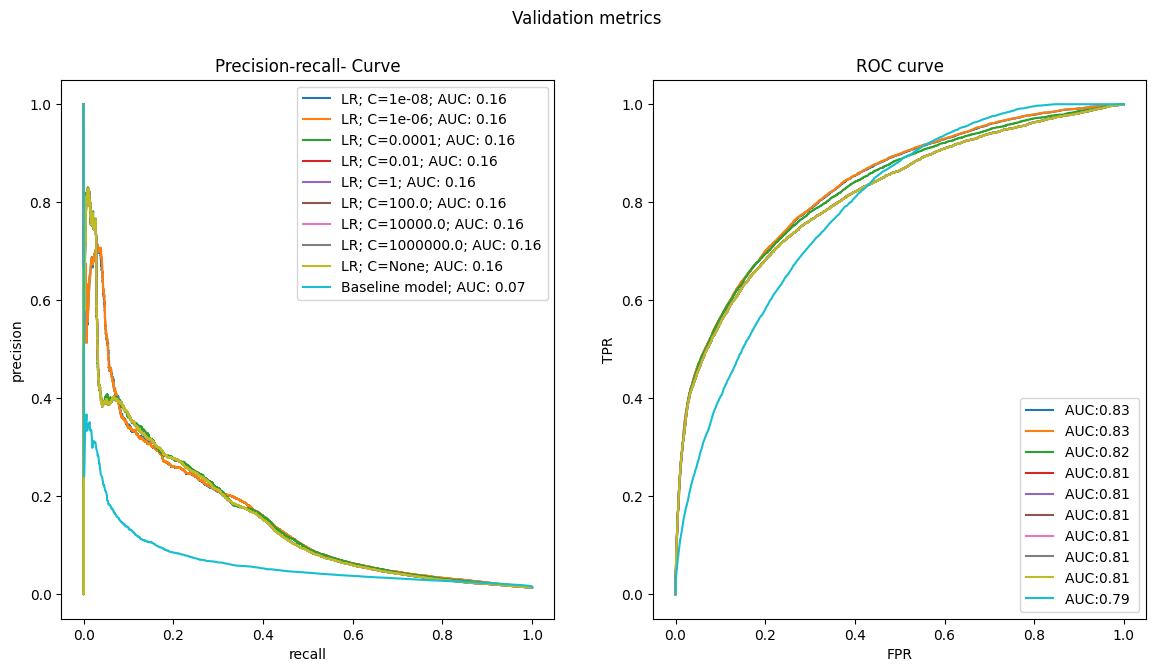

In [25]:
fig1, ax1 = plt.subplots(1,2, figsize=(14, 7 ))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2, figsize=(14, 7 ))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6, None]
for c in cs:
    lr = make_pipeline(
        StandardScaler(), # Z-Score normalization: makes all variables have mean = 0 and std = 1
        LogisticRegression(penalty="l2", C=c if c else 1.0)
    )

    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=y_val, figure=(fig2, ax2)
    ) 

plot_metrics(
    f"Baseline model",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    figure=(fig2, ax2)
)                                                   


- La parte izquierda de la curva P-R es muy "rara". Cuando tengo un Recall muy bajo, detecto muy pocos casos positivos lo que significa que el threshold debe de estar demasiado alto. n 

## Lasso Regression

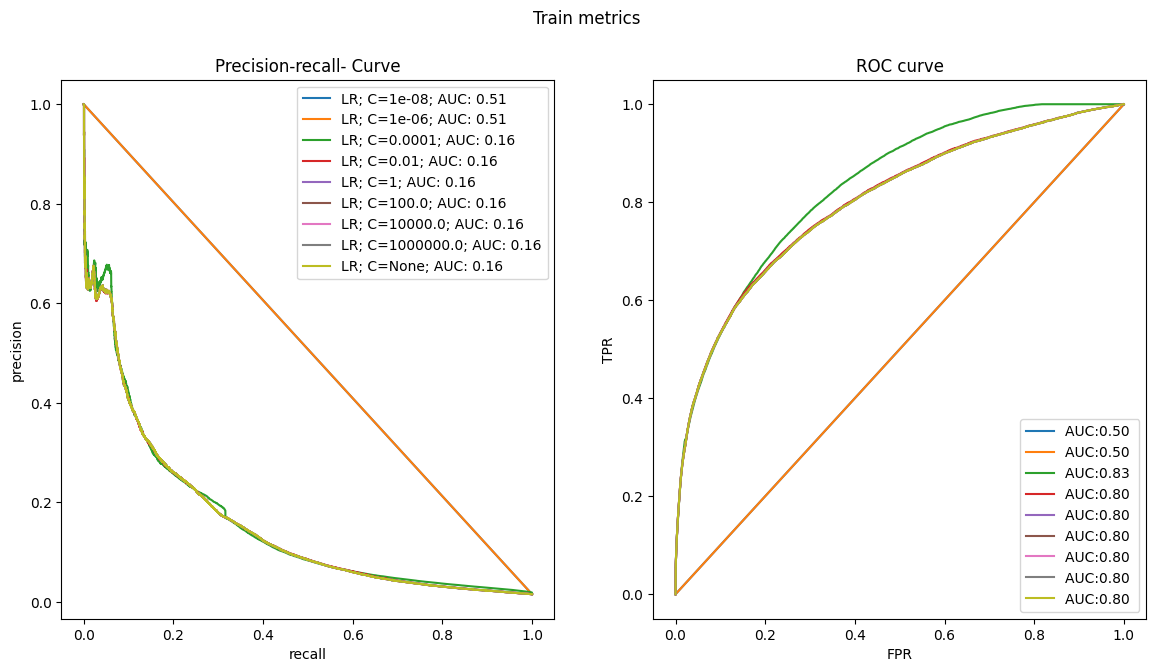

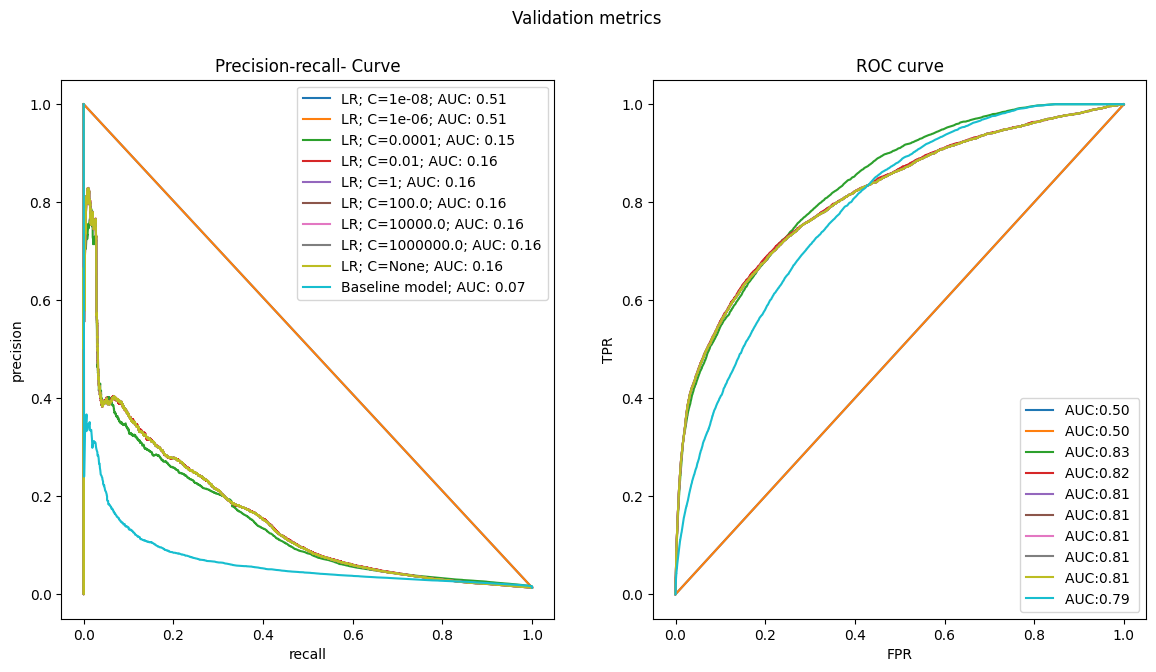

In [26]:
lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []

fig1, ax1 = plt.subplots(1,2, figsize=(14, 7 ))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2, figsize=(14, 7 ))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6, None]
for c in cs:
    lr = make_pipeline(
        StandardScaler(), # Z-Score normalization: makes all variables have mean = 0 and std = 1
        LogisticRegression(penalty="l1", solver="saga", C=c if c else 1.0)
    )

    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=y_val, figure=(fig2, ax2)
    ) 

plot_metrics(
    f"Baseline model",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    figure=(fig2, ax2)
)   

- La línea recta hace referencia a threshold=0 y threshold=1, esto es, predigo todo como positivos o no predigo nada como positivo.
- No parece haber una mejora significativa con la regularización Lasso, siendo los modelos muy similares a los de Ridge

## Coefficient weights

In [17]:
lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l2", C=1e-6))
    ]
)

lr.fit(X_train[train_cols], y_train)
lr_coeff_l2 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]), # Con esto, accedes al objeto LogisticRegression y obtienes los coeficientes con el método "coef_", que representa los pesos de cada feature
        "regularisation": "l2",
    }
)
lr_coeff_l2 = lr_coeff_l2.sort_values("importance", ascending=True)

lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l1", C=1e-4, solver="saga"))
    ]
)

lr.fit(X_train[train_cols], y_train)
lr_coeff_l1 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": "l1",
    }
)
lr_coeff_l1 = lr_coeff_l1.sort_values("importance", ascending=True)

<Axes: xlabel='importance', ylabel='features'>

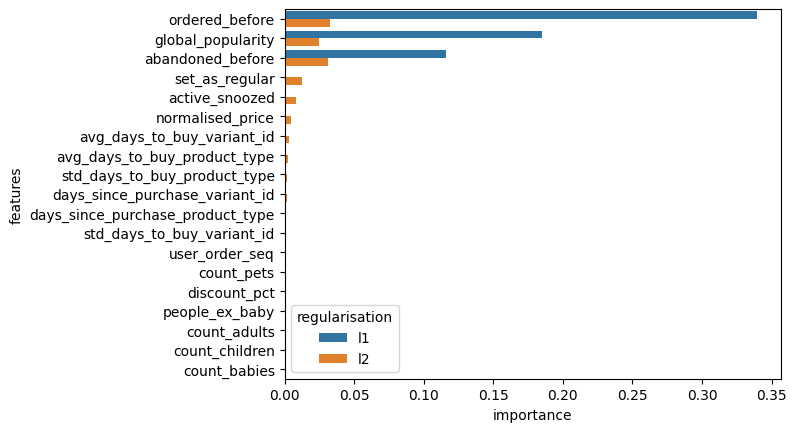

In [18]:
lr_coeffs = pd.concat([lr_coeff_l1, lr_coeff_l2])
lr_coeffs["features"] = pd.Categorical(lr_coeffs["features"])
lr_coeffs = lr_coeffs.sort_values(by="importance")
order_columns = lr_coeffs.sort_values(by="importance", ascending=False)["features"]
sns.barplot(
    data=lr_coeffs,
    x="importance",
    y="features",
    hue="regularisation", # Es como un groupby, en este caso group by "l1" y "l2"
    order=order_columns
)

Como se puede comprobar, según ambas regularizaciones, obtenemos claramente que las features con más "importancia" son:
- `ordered_before`
- `global_popularity`
- `abandoned_before`

La teoría se cumple:
- **Lasso**: se obtienen soluciones "sparse", lo que quiere decir que lleva la mayoría de pesos a 0
- **Ridge**: propone soluciones en la que todos los pesos son más pequeños, ya que estamos penalizando el cuadrado

## Feature selection

En base al análisis anterior, reentrenamos el modelo únicamente con las variables "importantes":
- `ordered_before`
- `global_popularity`
- `abandoned_before`

In [20]:
new_train_cols = ["ordered_before", "global_popularity", "abandoned_before"]

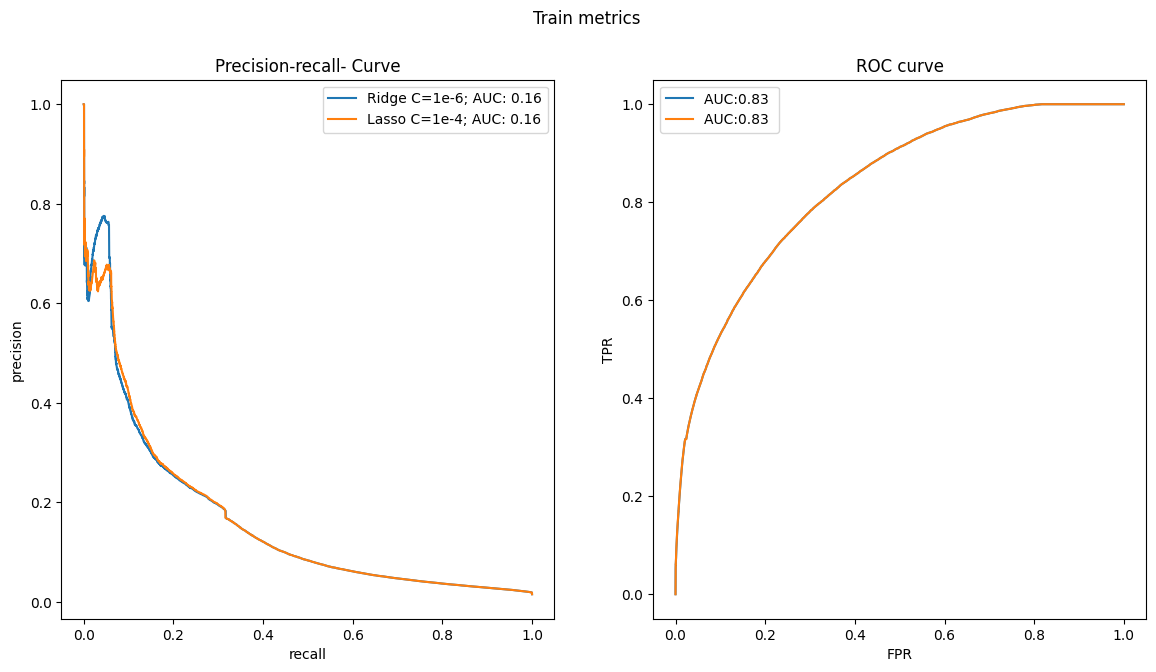

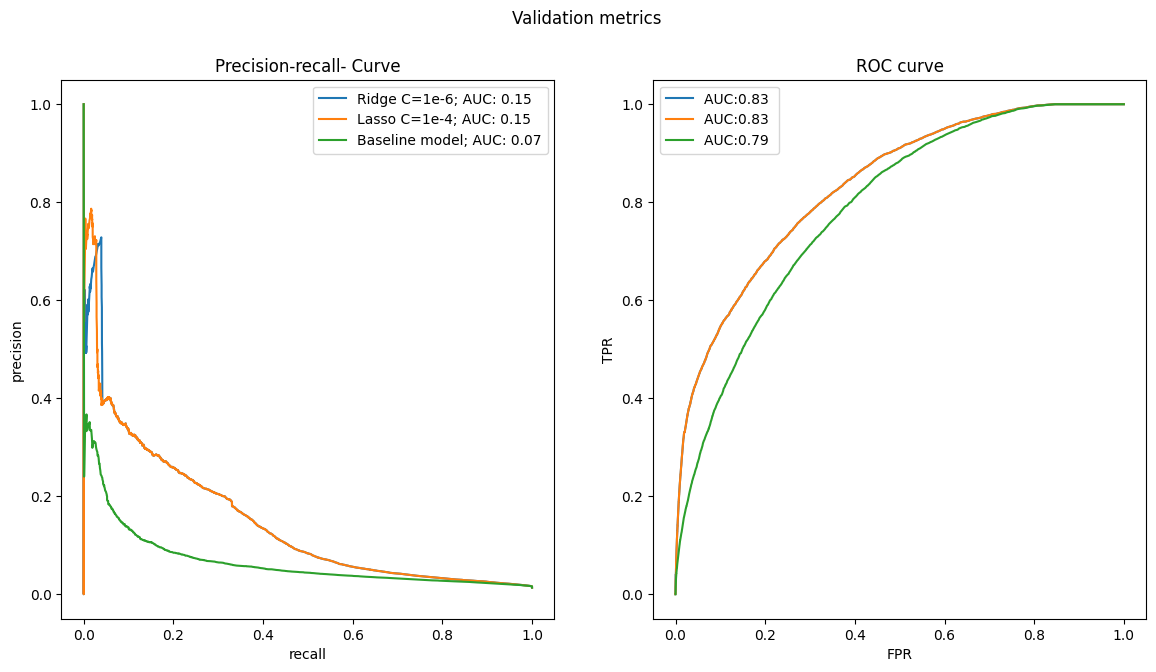

In [31]:
fig1, ax1 = plt.subplots(1,2, figsize=(14, 7 ))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2, figsize=(14, 7 ))
fig2.suptitle("Validation metrics")

names = ["Ridge C=1e-6", "Lasso C=1e-4"]
lrs = [
    make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-6)),
    make_pipeline(StandardScaler(), LogisticRegression(penalty="l1", C=1e-4, solver="saga"))
]

for name, lr in zip(names, lrs):
    lr.fit(X_train[new_train_cols], y_train)
    train_proba = lr.predict_proba(X_train[new_train_cols])[:, 1]
    plot_metrics(
        name, y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[new_train_cols])[:, 1]
    plot_metrics(
        name, y_pred=val_proba, y_test=y_val, figure=(fig2, ax2)
    ) 

plot_metrics(
    f"Baseline model",
    y_pred=val_df["global_popularity"],
    y_test=val_df[label_col],
    figure=(fig2, ax2)
)   
    

A priori, no se ve mucha diferencia entre usar Ridge o Lasso con las 3 variables con más "importancia".

## Models -module_4

En una primera aproximación, se va a probar con los siguientes modelos:
- DecisionTree Classifier
- Bagging
- Boosting

### Decision Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
dt = DecisionTreeClassifier(
    splitter="best",
    max_depth=1
)
dt.fit(X_train[train_cols], y_train)

DecisionTreeClassifier(max_depth=1)

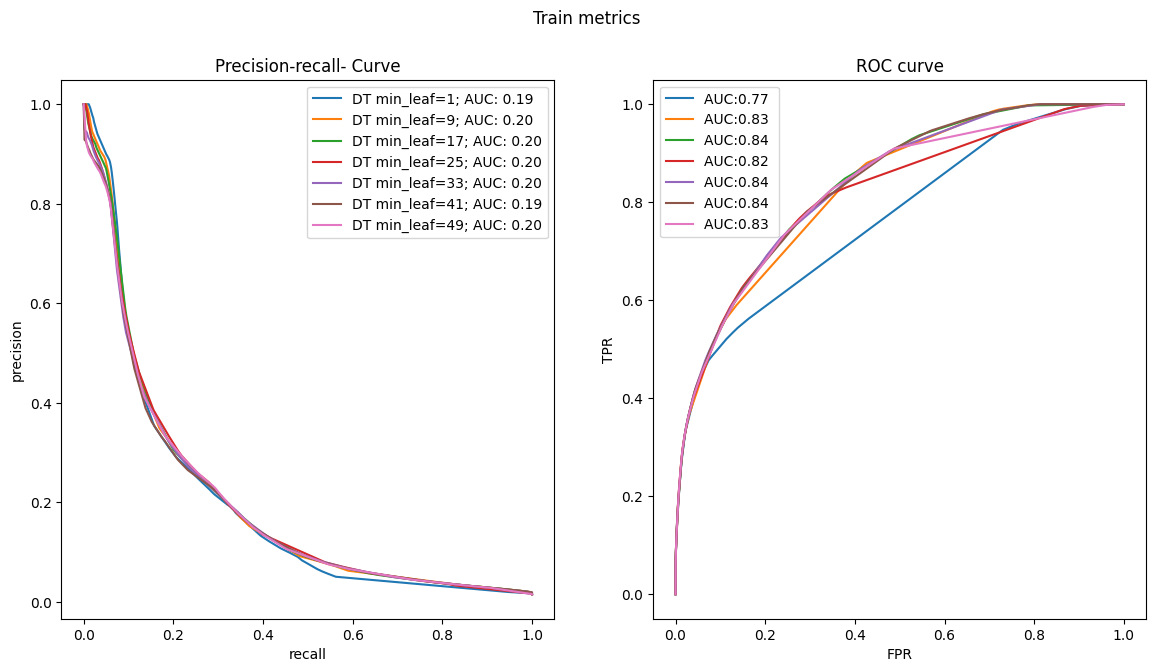

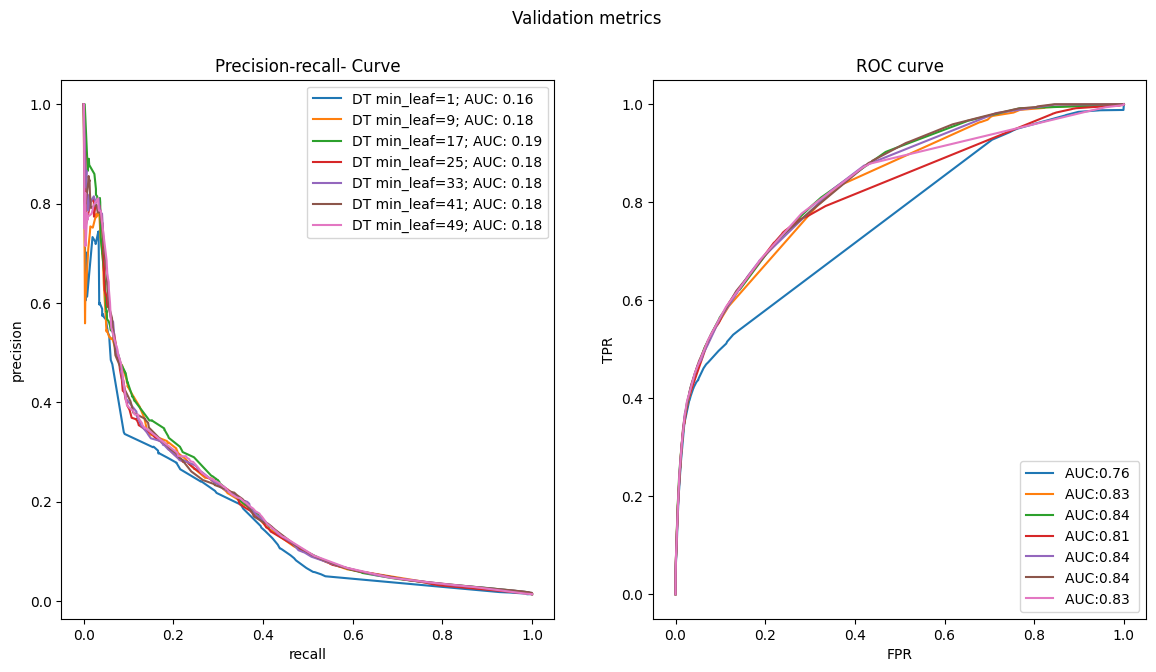

In [34]:
fig1, ax1 = plt.subplots(1,2, figsize=(14, 7 ))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2, figsize=(14, 7 ))
fig2.suptitle("Validation metrics")

ds = np.arange(1,50, 8)
for leaf in ds:
    dt = make_pipeline(
        DecisionTreeClassifier(
            splitter="random", 
            max_depth=10, 
            min_samples_split=8, 
            min_samples_leaf=leaf)
    )

    dt.fit(X_train[train_cols], y_train)
    train_proba = dt.predict_proba(X_train[train_cols])[:, 1]

    plot_metrics(
        f"DT min_leaf={leaf}", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )

    val_proba = dt.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"DT min_leaf={leaf}", y_pred=val_proba, y_test=y_val, figure=(fig2, ax2)
    ) 

In [35]:
dt_coeff = pd.DataFrame(
{
    "features": train_cols,
    "importance": np.abs(dt.named_steps["decisiontreeclassifier"].feature_importances_) 
}
)

dt_coeff.sort_values(by="importance", ascending=False)

,features,importance
15,ordered_before,0.358782
16,abandoned_before,0.323941
3,global_popularity,0.225970
18,set_as_regular,0.020930
14,std_days_to_buy_product_type,0.014242
12,days_since_purchase_product_type,0.011530
0,user_order_seq,0.011377
13,avg_days_to_buy_product_type,0.008950
10,avg_days_to_buy_variant_id,0.008459
11,std_days_to_buy_variant_id,0.004530


### Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

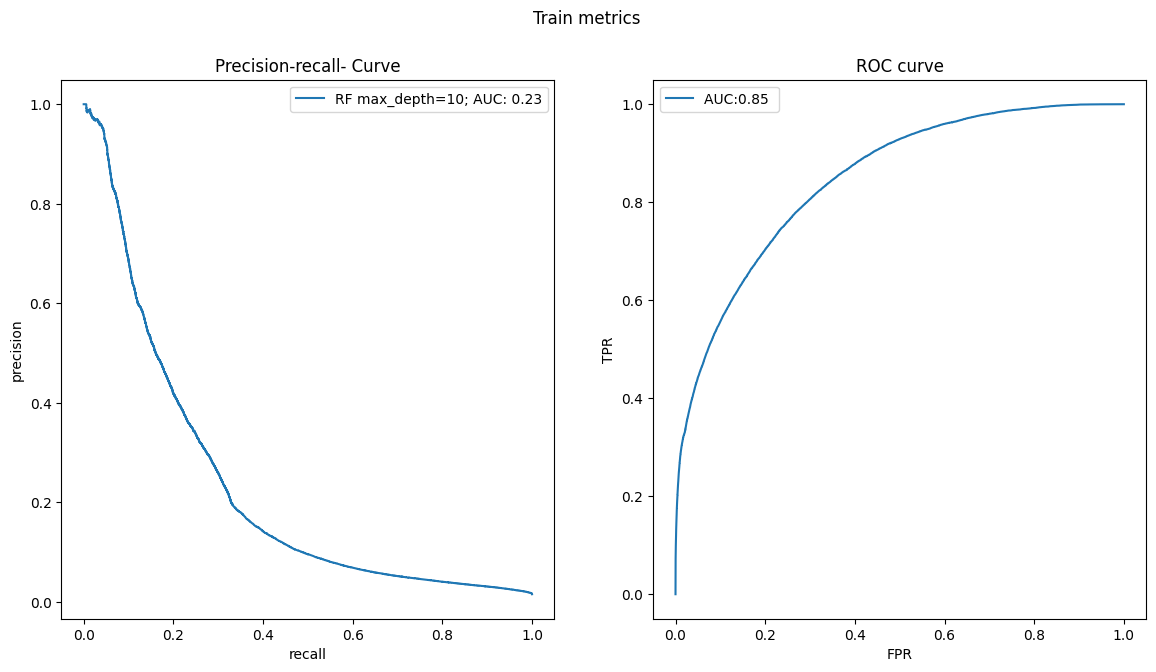

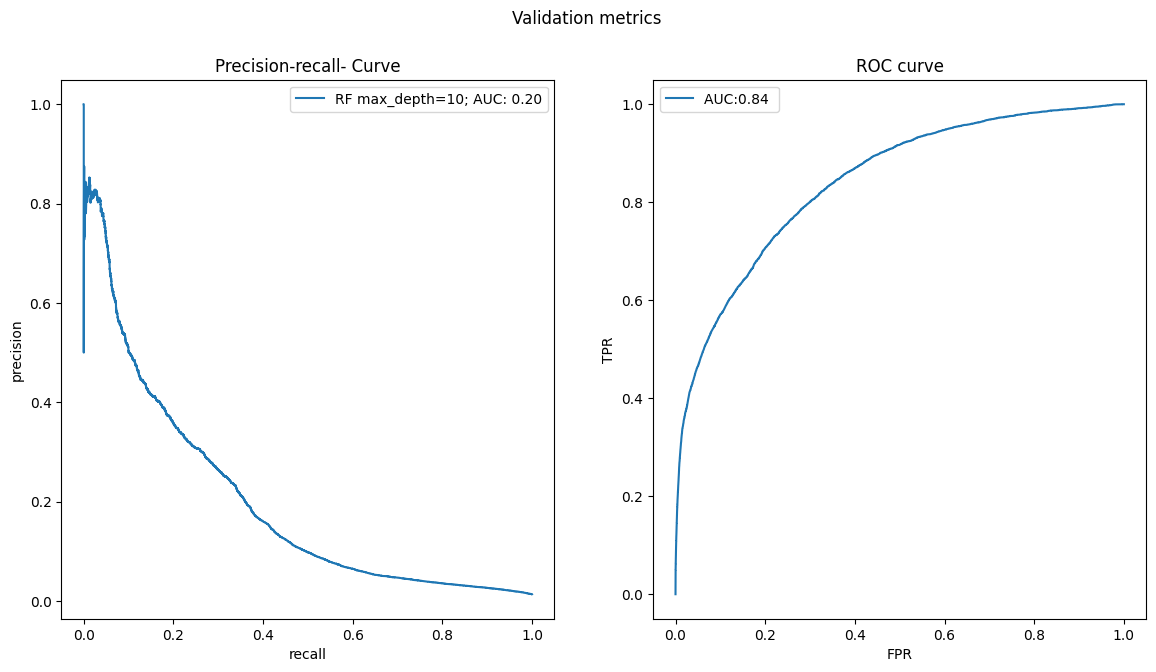

In [17]:
fig1, ax1 = plt.subplots(1,2, figsize=(14, 7 ))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2, figsize=(14, 7 ))
fig2.suptitle("Validation metrics")

parameters = [10]
for param in parameters:
    rf = make_pipeline(
        RandomForestClassifier(
            n_estimators=100,
            max_depth=param,
            min_samples_leaf=5) # mínimo número de muestras por hoja, cuanto menor, más riesgo de overfitting
    )

    rf.fit(X_train[train_cols], y_train)
    train_proba = rf.predict_proba(X_train[train_cols])[:, 1]

    plot_metrics(
        f"RF max_depth={param}", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )

    val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"RF max_depth={param}", y_pred=val_proba, y_test=y_val, figure=(fig2, ax2)
    ) 

- Se ha probado con diferentes configuraciones de hipermparámetros y se han seleccionado ``n_estimators=100``, ``max_depth=10`` y  ``min_samples_leaf=5``, ya que es con los que mejores resultados se obtienen. 


In [19]:
rf_coeff = pd.DataFrame(
{
    "features": train_cols,
    "importance": np.abs(rf.named_steps["randomforestclassifier"].feature_importances_) 
}
)

rf_coeff.sort_values(by="importance", ascending=False)

,features,importance
16,abandoned_before,0.281911
15,ordered_before,0.259223
3,global_popularity,0.153522
9,days_since_purchase_variant_id,0.080247
14,std_days_to_buy_product_type,0.029500
10,avg_days_to_buy_variant_id,0.029060
18,set_as_regular,0.025243
12,days_since_purchase_product_type,0.024121
13,avg_days_to_buy_product_type,0.023627
11,std_days_to_buy_variant_id,0.022312


In [25]:
new_cols = [feature for feature in rf_coeff.sort_values(by="importance", ascending=False)[:4].features.values]
new_cols

['abandoned_before',
 'ordered_before',
 'global_popularity',
 'days_since_purchase_variant_id']

Nos quedamos con las 4 features con mayor importancia según "feature_importances_": ``abandoned_before``, ``ordered_before``, ``global_popularity`` y ``days_since_purchase_variant_id`` y probamos para verificar si el modelo mejora sólo con estas features

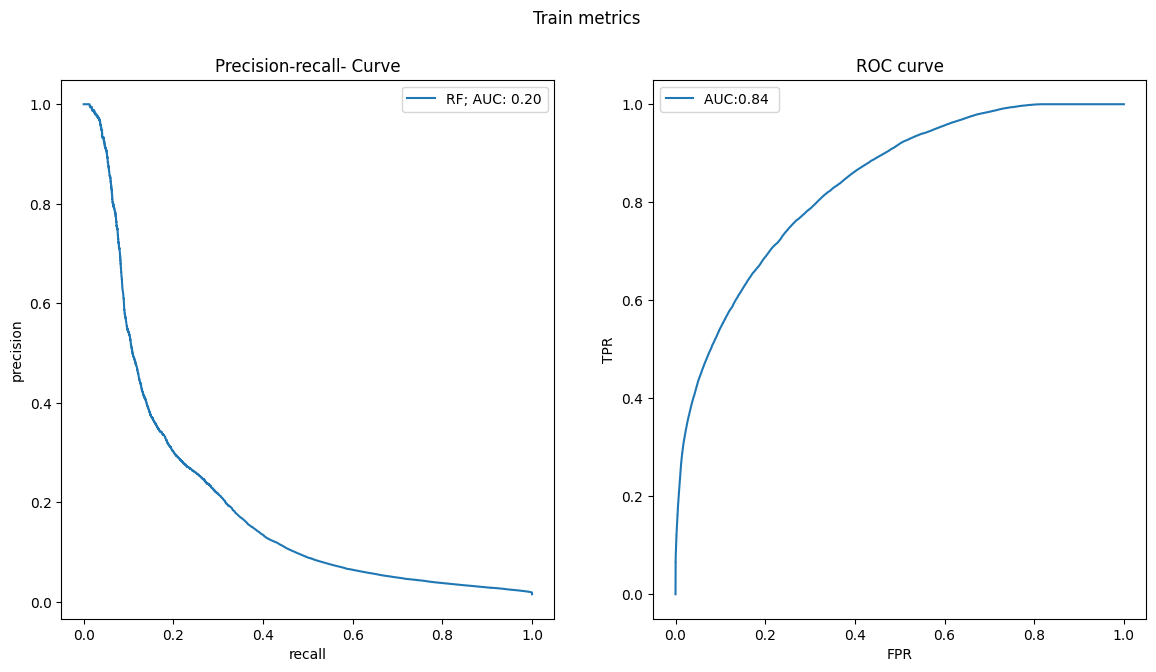

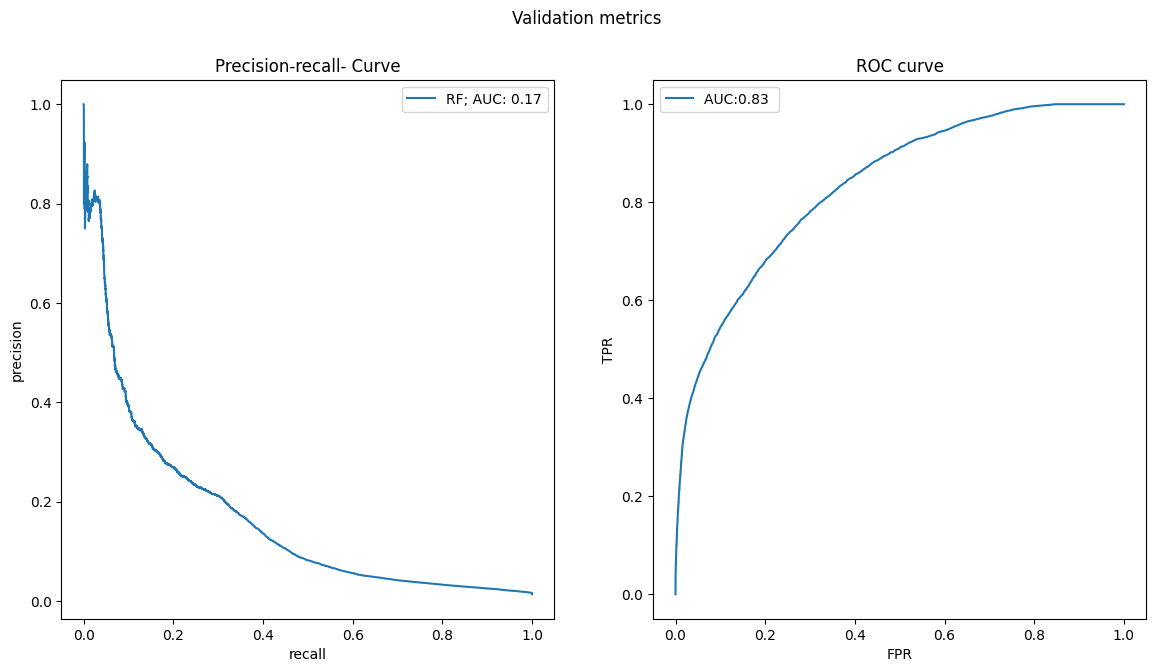

In [27]:
fig1, ax1 = plt.subplots(1,2, figsize=(14, 7 ))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2, figsize=(14, 7 ))
fig2.suptitle("Validation metrics")


rf = make_pipeline(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=5)
)

rf.fit(X_train[new_cols], y_train)
train_proba = rf.predict_proba(X_train[new_cols])[:, 1]

plot_metrics(
    f"RF", y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
)

val_proba = rf.predict_proba(X_val[new_cols])[:, 1]
plot_metrics(
    f"RF", y_pred=val_proba, y_test=y_val, figure=(fig2, ax2)
) 

Podemos comprobar que no hay gran mejora, incluso el modelo empeora ligeramente, por lo que seguiremos utilizando todas las featues ``train_cols``

### Gradient Boosting

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()

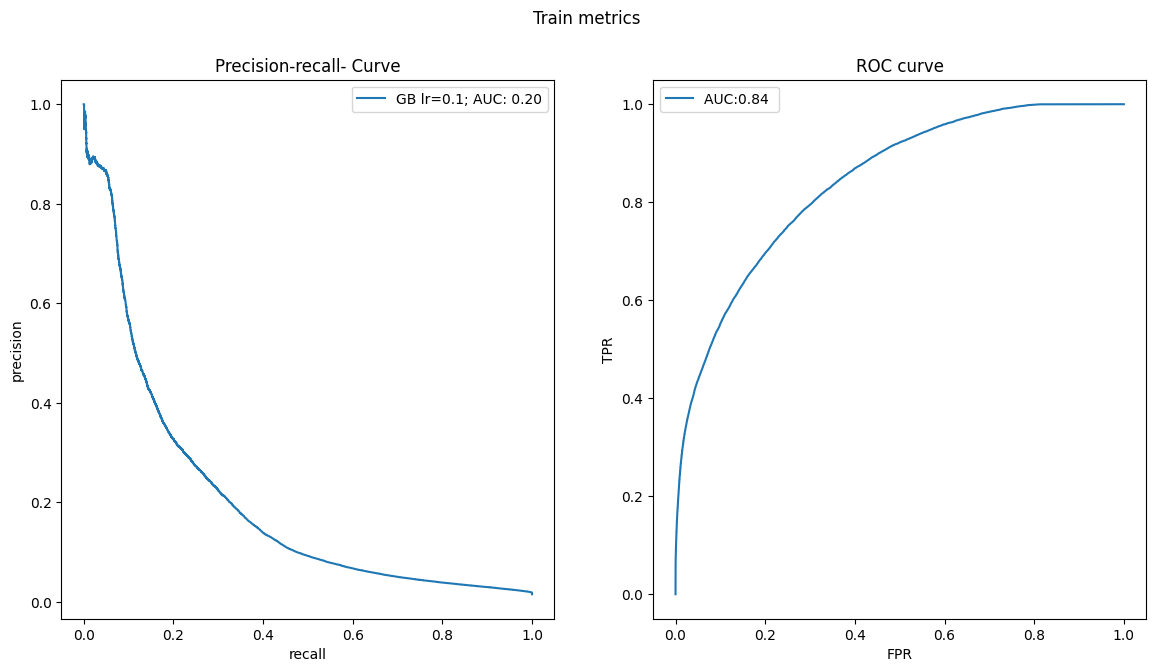

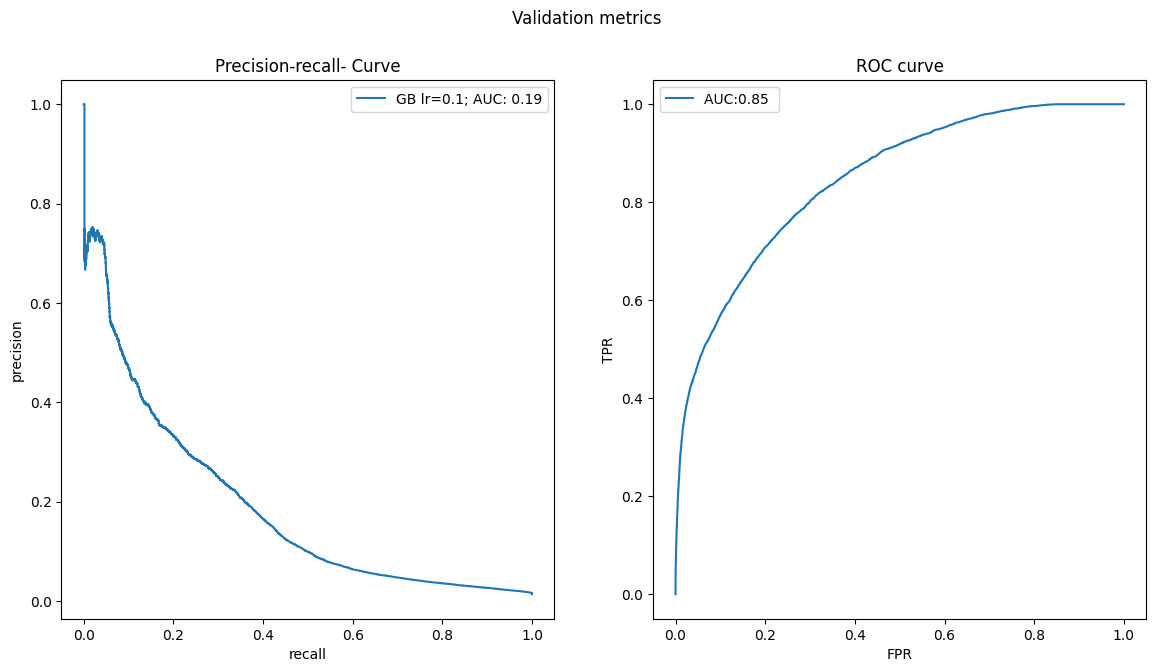

In [268]:
fig1, ax1 = plt.subplots(1,2, figsize=(14, 7 ))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2, figsize=(14, 7 ))
fig2.suptitle("Validation metrics")

learning_rates = [0.1]
for lr in learning_rates:
    gb = make_pipeline(
        GradientBoostingClassifier(
            learning_rate=lr
        )
    )

    gb.fit(X_train[train_cols], y_train)
    gb_train_proba = gb.predict_proba(X_train[train_cols])[:, 1]

    plot_metrics(
        f"GB lr={lr}", y_pred=gb_train_proba, y_test=y_train, figure=(fig1, ax1)
    )

    gb_val_proba = gb.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"GB lr={lr}", y_pred=gb_val_proba, y_test=y_val, figure=(fig2, ax2)
    ) 

Se comprueba que no hay gran diferencia entre RandomForest y GradientBoosting

In [172]:
gb.named_steps["gradientboostingclassifier"]

GradientBoostingClassifier()

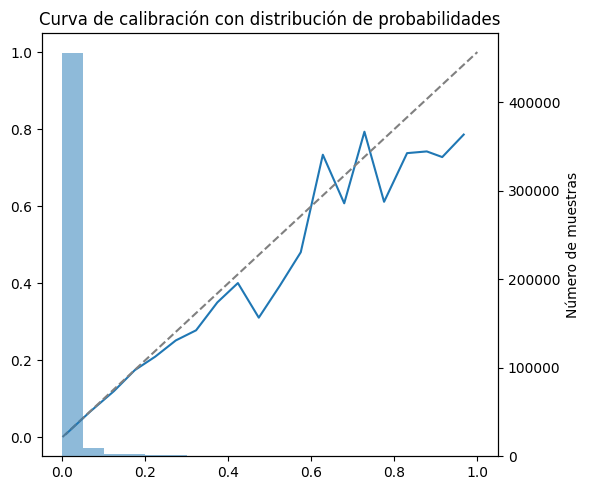

In [269]:
from sklearn.calibration import calibration_curve


def plot_calibration_curve(
        y_true: pd.Series,
        y_pred: np.ndarray, 
        *,
        n_bins: int
) -> None:
    fig, ax = plt.subplots(figsize=(6, 5))

    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins)

    ax.plot(prob_pred, prob_true)
    ax.plot([0, 1],[0, 1], color="grey",linestyle="--")

    # Segundo eje para el histograma (mismo eje X, diferente eje Y)
    ax2 = ax.twinx()
    ax2.hist(y_pred, bins=20, range=(0, 1), alpha=0.5, label='Distribución')
    ax2.set_ylabel('Número de muestras')

    # Añadir título y leyenda
    ax.set_title('Curva de calibración con distribución de probabilidades')

    plt.tight_layout()
    plt.show()

plot_calibration_curve(y_val, gb_val_proba, n_bins=20)


- Como se ve, la curva del modelo se asemeja bastante la recta donde y=x (calibración perfecta).
- No obstante, a medida que las predicciones van acercándose a 1, el modelo comienza a predecir por encima y por debajo de la diagonal. Esto puede deberse a que la clase positiva es minoritaria (hay muchas menos observaciones de la clase 1), con lo cual la estimación de la proporción de TP en esos rangos se vuelve más inestable y genera fluctuaciones en la curva.

In [270]:
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

gbt = gb.named_steps["gradientboostingclassifier"]

calibrated_gbt = CalibratedClassifierCV(gbt, method="isotonic", cv="prefit")
calibrated_gbt.fit(X_val[train_cols], y_val)
calibrated_val_proba = calibrated_gbt.predict_proba(X_val[train_cols])[:,1]

# calibrated_gbt.fit(X_test[train_cols], y_test)
calibrated_test_proba = calibrated_gbt.predict_proba(X_test[train_cols])[:,1]


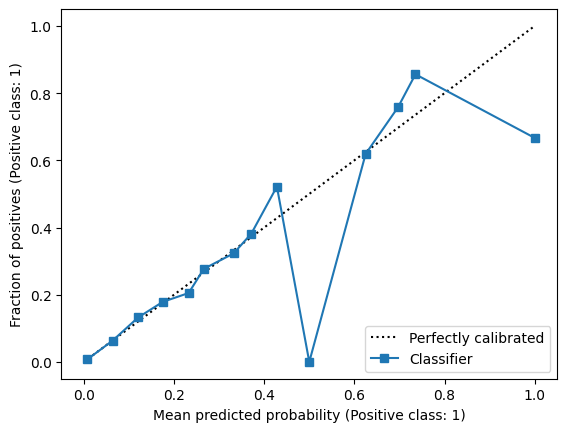

In [271]:
CalibrationDisplay.from_predictions(
    y_test,
    calibrated_test_proba,
    n_bins=20
)

Tras calibrar con el conjunto de **validación** y evaluar con el conjunto de **test**, se aprecia que a partir de cierto umbral deja de estar bien calibrado. Esto es debido, como se comentó anteriormente, a que la clase positiva es minoritaria, lo que provoca que en los bins con probabilidades altas haya muy pocas muestras.
Por tanto, el modelo muestra mayor inestabilidad y menor confianza al predecir la clase positiva en esos rangos.

In [193]:
import xgboost as xgb

In [194]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,       
    learning_rate=0.05,     
    max_depth=5,            
    subsample=0.8,         
    random_state=42,
    n_jobs=-1,             
    eval_metric='logloss'   
)

In [196]:
xgb_model.fit(X_train[train_cols], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

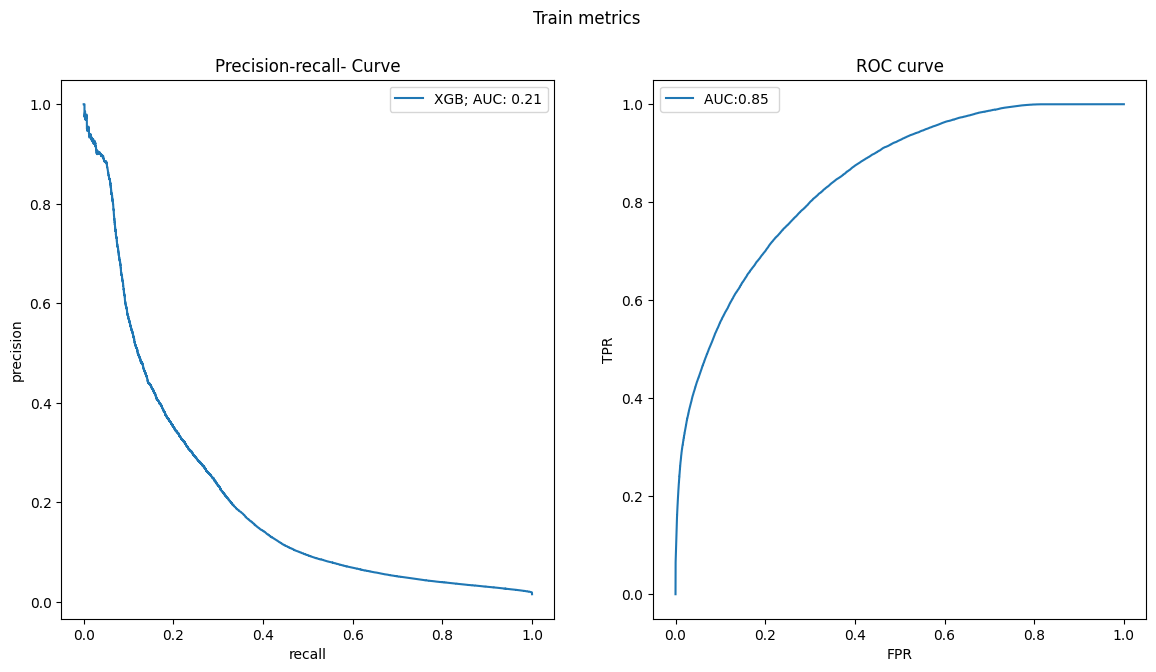

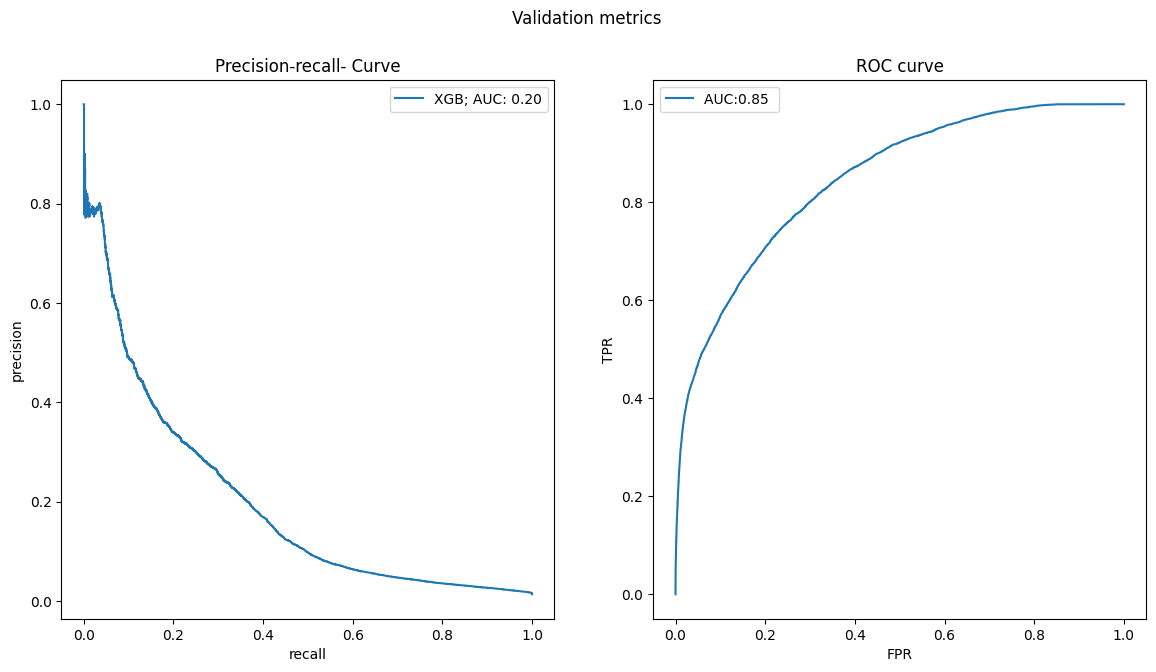

In [382]:
fig1, ax1 = plt.subplots(1,2, figsize=(14, 7 ))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1,2, figsize=(14, 7 ))
fig2.suptitle("Validation metrics")

model_name = "XGB"

xgb_model = xgb.XGBClassifier(
    n_estimators=100,       
    learning_rate=0.05,     
    max_depth=5,       
    # random_state=42,
    # n_jobs=-1,             
    eval_metric='logloss'
    )

xgb_model.fit(X_train[train_cols], y_train)
xgb_train_proba = xgb_model.predict_proba(X_train[train_cols])[:, 1]

plot_metrics(
    f"{model_name}", y_pred=xgb_train_proba, y_test=y_train, figure=(fig1, ax1)
)

xgb_val_proba = xgb_model.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"{model_name}", y_pred=xgb_val_proba, y_test=y_val, figure=(fig2, ax2)
) 

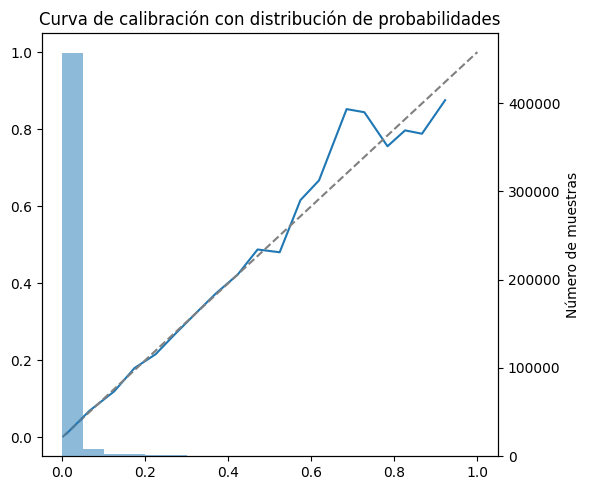

In [273]:
plot_calibration_curve(y_val, xgb_val_proba, n_bins=20)

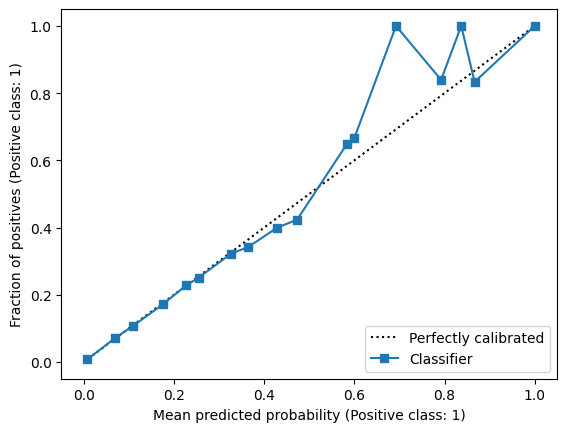

In [278]:
calibrated_xgb = CalibratedClassifierCV(xgb_model, method="isotonic", cv="prefit")
calibrated_xgb.fit(X_val[train_cols], y_val)
calibrated_xgb_val_proba = calibrated_xgb.predict_proba(X_val[train_cols])[:,1]
calibrated_xgb_test_proba = calibrated_xgb.predict_proba(X_test[train_cols])[:,1]

CalibrationDisplay.from_predictions(
    y_test,
    calibrated_xgb_test_proba,
    n_bins=20
)

En este caso, la calibración empeora el modelo. Nos quedamos con el modelo sin calibrar, el cual tiene una performance aceptable

### Results

Se aplicará un ``threshold = 0.05``

In [288]:
threshold = 0.05
y_test_proba = xgb_model.predict_proba(X_test[train_cols])[:,1]
y_test_pred = (y_test_proba >= threshold).astype(int)
y_test_pred

array([0, 0, 1, ..., 0, 0, 0])

In [373]:
from sklearn.metrics import precision_score, recall_score

precision_threshold = precision_score(y_test, y_test_pred)
recall_threshold = recall_score(y_test, y_test_pred)

print(precision_threshold)
print(recall_threshold)

0.15036622145626885
0.4115566037735849


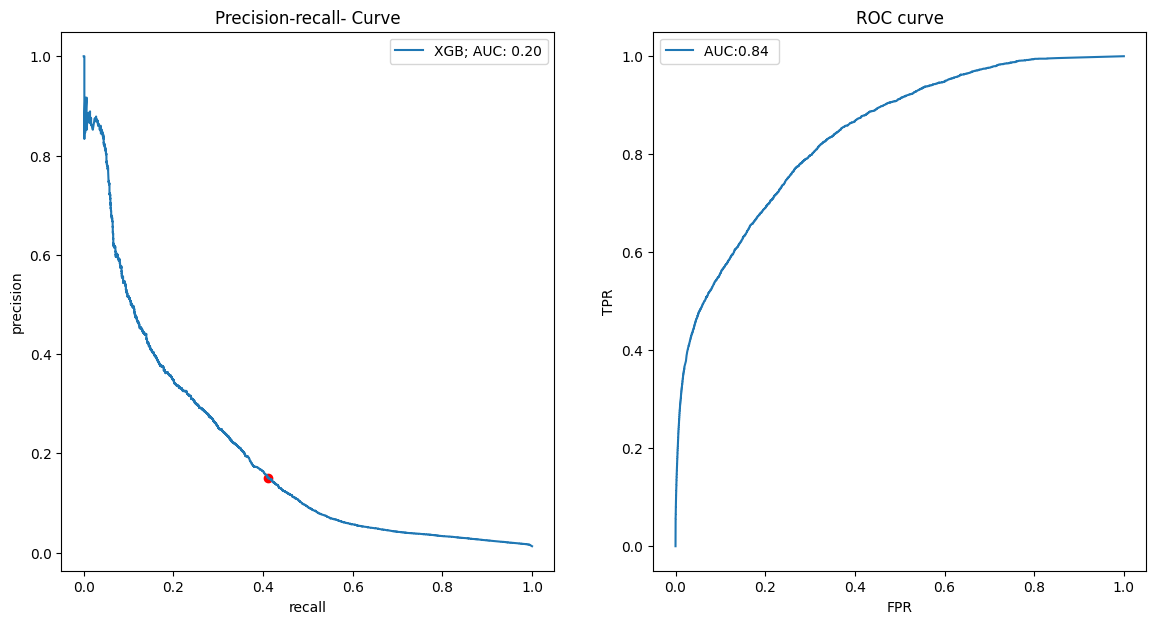

In [379]:
precision_, recall_, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall_, precision_)

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].plot(recall_, precision_, label=f"XGB; AUC: {pr_auc:.2f}")
ax[0].scatter(recall_threshold, precision_threshold, c="r")
ax[0].set_xlabel("recall")
ax[0].set_ylabel("precision")
ax[0].set_title("Precision-recall- Curve")
ax[0].legend()

ax[1].plot(fpr, tpr, label=f"AUC:{roc_auc:.2f} ")
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
ax[1].set_title("ROC curve")
ax[1].legend()


Graficamos el punto de trabajo, que corresponde a un ``threshold = 0.05``. Esto implica que las predicciones cuya probabilidad de pertenecer a la clase positiva sea al menos del 5%, serán clasificadas como positivas. Este threshold tan "bajo" hace que el modelo tenga un recall del 41% y una precisión del 15%:
- **Recall**: el 41% de los productos que el usuario va a comprar se les manda la notificación
- **Precision**: sólo el 15% de las notificaciones terminan en compra

(?) No lo termino de entender

(Objetivo: dado un usuario y un producto, predecir si el usuario comprará o no)

In [383]:
import time

timestamp = time.strftime("%Y_%m_%d-%H%M")
default_model_name = f"{model_name}_{timestamp}.pkl"
default_model_name

'XGB_2025_11_02-1155.pkl'

In [ ]:
def handler_fit(event, _):
    model_parametrisation = event["model_parametrisation"]
    # [your code here]
    return {
        "statusCode": "200",
        "body": json.dumps(
            {"model_path": [your_model_stored_path]
             }
             ),
    }